Inverse heat equation with space dependent diffusion $D$
========================================================
In this example we want to solve a inverse problem where the parameter we are looking for is also a function.
We consider, $\Omega = [0, 10] \times [0, 10]$ and:
\begin{align*}
 \text{div}(D(x)\nabla u(x, t)) &= \partial_t u(x, t) \text{ in } \Omega \times [0, 5]\\
 u(x, 0) &= 100\sin(\tfrac{\pi}{10}x_1)\sin(\tfrac{\pi}{10}x_2)  \text{ in } \Omega \\
 u(x, t) &= 0 \text{ on } \partial \Omega \times [0, 5]
\end{align*}  
The diffusion will be given by: $D(x)=5e^{-\tfrac{1}{20}((x_1-3)^2 + (x_2-3)^2)}$. 

With an external program, we computed a FEM solution of this equation. The data can be found under the data folder.
This forward solution will be used as input data for the inverse problem.

Since $D$ is a function too, we will use two neural networks. One for the temperature $u$ and for $D$. They will be connected over the PDE.

In [1]:
import torchphysics as tp
import pytorch_lightning as pl
import torch
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "2" # select GPUs to use

The spaces and domains are defined like always:

In [2]:
X = tp.spaces.R2('x')
T = tp.spaces.R1('t')

D = tp.spaces.R1('D')
U = tp.spaces.R1('u')

In [3]:
w, h = 10, 10
t_0, t_end = 0, 5

domain_x = tp.domains.Parallelogram(X, [0, 0], [w, 0], [0, h])
domain_t = tp.domains.Interval(T, t_0, t_end)

Here we now have two networks, like previously mentioned.
In the PDE both networks have to be evaluated, therefore we use the parallel evaluation of ``tp.models.Parallel``.
This objects will evaluate all models in parallel and pass the output to the corresponding condition.

In [4]:
model_u = tp.models.Sequential(
            tp.models.NormalizationLayer(domain_x*domain_t),
            tp.models.FCN(input_space=X*T, output_space=U, hidden=(80,80,50,50)))
model_D = tp.models.Sequential(
            tp.models.NormalizationLayer(domain_x),
            tp.models.FCN(input_space=X, output_space=D, hidden=(80,80,50,50))) # D only has X as an Input
parallel_model = tp.models.Parallel(model_u, model_D)

Here we load the data of the forward problem. There are around, 90000 data points, we take only some random ones of them. This is chosen with ``num_of_data ``. 
The data is in the form: [time, x-coordinates, temperature].

After we have picked some points, we transform them to a ``Points``-object, so we can use the data in training.

In [5]:
import numpy as np
solution_data = np.load('data/heat-eq-inverse-data.npy')
num_of_data = 30000
solution_data = solution_data[np.random.choice(len(solution_data), num_of_data, replace=False), :].astype(np.float32)
solution_data = torch.tensor(solution_data)
inp_data = tp.spaces.Points.from_coordinates({'x': solution_data[:, 1:3], 't': solution_data[:, :1]})
out_data = tp.spaces.Points.from_coordinates({'u': solution_data[:, 3:]})

The data will be put in a ``PointsDataLoader``, that will pass the data to the condition. 
As a condition, we will here use a ``DataCondition`` that just compares the output of the model with the expected values.

In this condition, we only train the model of temperature, since we only have data of the temperature. 

In [6]:
data_loader = tp.utils.PointsDataLoader((inp_data, out_data), batch_size=num_of_data)
data_condition = tp.conditions.DataCondition(module=model_u,
                                             dataloader=data_loader,
                                             norm=2, 
                                             use_full_dataset=True) 

For the differential equation we have to create some points inside the domain and check there the PDE.
Here, both models will be used, since $D$ and $u$ have to fulfill this condition together. 

In [7]:
inner_sampler = tp.samplers.RandomUniformSampler(domain_x*domain_t, n_points=15000)

def heat_residual(u, x, t, D):
    return tp.utils.div(D*tp.utils.grad(u, x), x) - tp.utils.grad(u, t)

pde_condition = tp.conditions.PINNCondition(module=parallel_model, # use parallel evaluation
                                            sampler=inner_sampler,
                                            residual_fn=heat_residual,
                                            name='pde_condition', 
                                            weight=100)

This is all we have to do. In total, the definition is not much different from the inverse problem with a constant $D$. Now we can start the training:

In [8]:
optim = tp.OptimizerSetting(optimizer_class=torch.optim.Adam, lr=0.001)

solver = tp.solver.Solver([pde_condition, data_condition])

trainer = pl.Trainer(gpus=1,
                     max_steps=8000,
                     logger=False,
                     benchmark=True,
                     checkpoint_callback=False)
                     
trainer.fit(solver)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [2]

  | Name             | Type       | Params
------------------------------------------------
0 | train_conditions | ModuleList | 26.8 K
1 | val_conditions   | ModuleList | 0     
------------------------------------------------
26.8 K    Trainable params
0         Non-trainable params
26.8 K    Total params
0.107     Total estimated model params size (MB)


Validation sanity check: 0it [00:00, ?it/s]

/home/tomfre/miniconda3/envs/bosch/lib/python3.9/site-packages/pytorch_lightning/utilities/distributed.py:69: UserWarning: The dataloader, val dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 20 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  warnings.warn(*args, **kwargs)
/home/tomfre/miniconda3/envs/bosch/lib/python3.9/site-packages/pytorch_lightning/utilities/distributed.py:69: UserWarning: The dataloader, train dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 20 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  warnings.warn(*args, **kwargs)


Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

In [9]:
optim = tp.OptimizerSetting(optimizer_class=torch.optim.LBFGS, lr=0.5, 
                            optimizer_args={'max_iter': 2, 'history_size': 100})

# make sampler static.
pde_condition.sampler = pde_condition.sampler.make_static()

solver = tp.solver.Solver([pde_condition, data_condition], optimizer_setting=optim)

trainer = pl.Trainer(gpus=1,
                     max_steps=10000, # number of training steps
                     logger=False,
                     benchmark=True,
                     checkpoint_callback=False)
                     
trainer.fit(solver)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [2]

  | Name             | Type       | Params
------------------------------------------------
0 | train_conditions | ModuleList | 26.8 K
1 | val_conditions   | ModuleList | 0     
------------------------------------------------
26.8 K    Trainable params
0         Non-trainable params
26.8 K    Total params
0.107     Total estimated model params size (MB)


Validation sanity check: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Now we can have look at the learned diffusion:

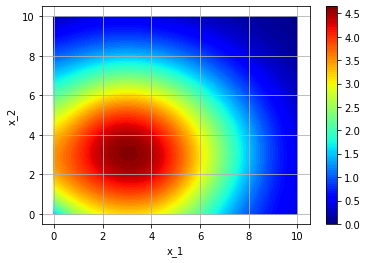

In [10]:
plot_sampler = tp.samplers.PlotSampler(plot_domain=domain_x, n_points=760, device='cuda')
fig = tp.utils.plot(model_D, lambda D : D, plot_sampler, plot_type='contour_surface')

Here the exact function:

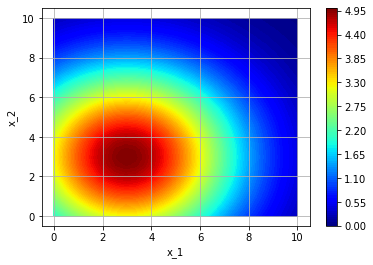

In [11]:
def exact(x):
    return 5*torch.exp(-1/20.0 * ((x[:, :1] - 3)**2 + (x[:, 1:] - 3)**2))

fig = tp.utils.plot(model_D, exact, plot_sampler, plot_type='contour_surface')

And the absolute error:

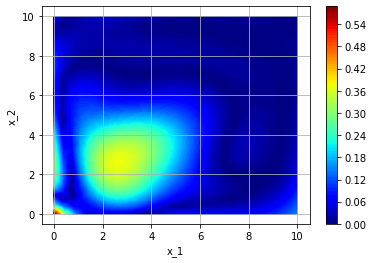

In [12]:
def error(D, x):
    return torch.abs(5*torch.exp(-1/20.0 * ((x[:, :1] - 3)**2 + (x[:, 1:] - 3)**2)) - D)

fig = tp.utils.plot(model_D, error, plot_sampler, plot_type='contour_surface')

MovieWriter ffmpeg unavailable; using Pillow instead.


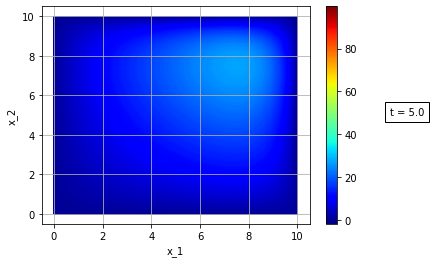

In [13]:
anim_sampler = tp.samplers.AnimationSampler(domain_x, domain_t, 200, n_points=760)
#fig, anim = tp.utils.animate(model_u, lambda u: u, anim_sampler, ani_speed=10, ani_type='contour_surface')
#anim.save('inverse-heat-eq.gif')